## Data Cleaning

## Objectives

## Inputs

## Outputs




# Change working directory

We need to change the working directory from its current folder to its parent folder



In [1]:
import os
current_dir = os.getcwd()
current_dir

'/Users/allaafaham/Library/Mobile Documents/com~apple~CloudDocs/cursor projects/house-prices/notebooks'

We want to make the parent of the current directory the new current directory



In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory



In [3]:
current_dir = os.getcwd()
current_dir

'/Users/allaafaham/Library/Mobile Documents/com~apple~CloudDocs/cursor projects/house-prices'

In [4]:
import pandas as pd

df = pd.read_csv("outputs/datasets/collection/house_prices_records.csv")
df.head(5)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500
3,961,NaN,NaN,No,216,ALQ,540,NaN,642,Unf,...,60.0,0.0,35,5,7,756,NaN,1915,1970,140000
4,1145,NaN,4.0,Av,655,GLQ,490,0.0,836,RFn,...,84.0,350.0,84,5,8,1145,NaN,2000,2000,250000


## Handle missing data

In [5]:
def EvaluateMissingData(df):
    missing_data_absolute = df.isnull().sum()
    missing_data_percentage = round(missing_data_absolute/len(df)*100, 2)
    df_missing_data = (pd.DataFrame(
                            data={"RowsWithMissingData": missing_data_absolute,
                                   "PercentageOfDataset": missing_data_percentage,
                                   "DataType": df.dtypes}
                                    )
                          .sort_values(by=['PercentageOfDataset'], ascending=False)
                          .query("PercentageOfDataset > 0")
                          )

    return df_missing_data

In [6]:
EvaluateMissingData(df)


,RowsWithMissingData,PercentageOfDataset,DataType
EnclosedPorch,1324,90.68,float64
WoodDeckSF,1305,89.38,float64
LotFrontage,259,17.74,float64
GarageFinish,235,16.10,object
BsmtFinType1,145,9.93,object
BedroomAbvGr,99,6.78,float64
2ndFlrSF,86,5.89,float64
GarageYrBlt,81,5.55,float64
BsmtExposure,38,2.60,object
MasVnrArea,8,0.55,float64


## Train-Test Split Before Data Cleaning

The following cell performs the train-test split **before any data cleaning**. This step is critical to ensure the integrity and validity of the machine learning workflow. Splitting prior to preprocessing prevents data leakage and ensures that model evaluation reflects performance on truly unseen data.

This strategy adheres to standard practices in supervised learning and supports reproducible, contamination-free modeling.


In [7]:
from sklearn.model_selection import train_test_split

TrainSet, TestSet = train_test_split(
    df,
    test_size=0.2,
    random_state=42
)

print(f"TrainSet shape: {TrainSet.shape}")
print(f"TestSet shape: {TestSet.shape}")

TrainSet shape: (1168, 24)
TestSet shape: (292, 24)


## Missing Data Handling Strategy

The dataset contains several features with missing values. The following imputation and data cleaning strategies were applied based on domain-specific assumptions and the extent of missingness:

- `2ndFlrSF`: Missing values were filled with `0`, under the assumption that no second floor exists for those entries.
- `BedroomAbvGr`: Filled using the median value, assuming missing entries reflect data omissions, as all houses are expected to have at least one bedroom above ground.
- `BsmtExposure`, `BsmtFinType1`: Imputed with `'None'`, indicating that the property lacks a basement.
- `GarageFinish`: Missing values replaced with `'None'`, reflecting absence of a garage.
- `GarageYrBlt`: Filled with `0`, representing properties with no garage structure.
- `LotFrontage`: Imputed using the median value due to its moderate level of missingness and expected variability across properties.
- `MasVnrArea`: Filled with `0`, assuming absence of masonry veneer in those cases.

In addition, the following features were dropped due to excessive missing data (greater than 85%):

- `EnclosedPorch`
- `WoodDeckSF`

These features were considered non-informative under the current modeling assumptions and would introduce bias or noise if retained.


In [9]:
from feature_engine.imputation import MeanMedianImputer, CategoricalImputer, ArbitraryNumberImputer
from sklearn.pipeline import Pipeline

# Imputation pipeline: only for the training set
cleaning_pipeline = Pipeline(steps=[
    ('impute_median', MeanMedianImputer(
        imputation_method='median',
        variables=['BedroomAbvGr', 'LotFrontage']
    )),
    
    ('impute_categorical', CategoricalImputer(
    imputation_method='missing',
    variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish']
    )), 
    ('impute_zero', ArbitraryNumberImputer(
        arbitrary_number=0,
        variables=['2ndFlrSF', 'GarageYrBlt', 'MasVnrArea']
    ))
])

# Fit and transform only on training set
TrainSet_cleaned = cleaning_pipeline.fit_transform(TrainSet)


/Users/allaafaham/Library/Mobile Documents/com~apple~CloudDocs/cursor projects/house-prices/house-prices-env-py311/lib/python3.11/site-packages/feature_engine/imputation/categorical.py:232: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[variable]):


In [10]:
from feature_engine.selection import DropFeatures

# Drop the same features from both sets
dropper = DropFeatures(features_to_drop=['EnclosedPorch', 'WoodDeckSF'])

# Apply to both sets
TrainSet_cleaned = dropper.fit_transform(TrainSet_cleaned)
TestSet_cleaned = dropper.transform(TestSet.copy())  # only transform the test set

In [11]:
print("Original shape:", TrainSet.shape)
print("Cleaned shape:", TrainSet_cleaned.shape)

print("Original shape:", TestSet.shape)
print("Cleaned shape:", TestSet_cleaned.shape)

Original shape: (1168, 24)
Cleaned shape: (1168, 22)
Original shape: (292, 24)
Cleaned shape: (292, 22)


In [12]:
EvaluateMissingData(TrainSet_cleaned)


,RowsWithMissingData,PercentageOfDataset,DataType


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps


def heatmap_corr(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=bool)
        mask[np.triu_indices_from(mask)] = True
        mask[abs(df) < threshold] = True

        fig, axes = plt.subplots(figsize=figsize)
        sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                    mask=mask, cmap='viridis', annot_kws={"size": font_annot}, ax=axes,
                    linewidth=0.5
                    )
        axes.set_yticklabels(df.columns, rotation=0)
        plt.ylim(len(df.columns), 0)
        plt.show()


def heatmap_pps(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=bool)
        mask[abs(df) < threshold] = True
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                         mask=mask, cmap='rocket_r', annot_kws={"size": font_annot},
                         linewidth=0.05, linecolor='grey')
        plt.ylim(len(df.columns), 0)
        plt.show()


def CalculateCorrAndPPS(df):
    df_corr_spearman = df.corr(method="spearman", numeric_only=True)
    df_corr_pearson = df.corr(method="pearson", numeric_only=True)

    pps_matrix_raw = pps.matrix(df)
    pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')

    pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T
    print("PPS threshold - check PPS score IQR to decide threshold for heatmap \n")
    print(pps_score_stats.round(3))

    return df_corr_pearson, df_corr_spearman, pps_matrix


def DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix, CorrThreshold, PPS_Threshold,
                      figsize=(20, 12), font_annot=8):

    print("\n")
    print("* Analyse how the target variable for your ML models are correlated with other variables (features and target)")
    print("* Analyse multi-colinearity, that is, how the features are correlated among themselves")

    print("\n")
    print("*** Heatmap: Spearman Correlation ***")
    print("It evaluates monotonic relationship \n")
    heatmap_corr(df=df_corr_spearman, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Pearson Correlation ***")
    print("It evaluates the linear relationship between two continuous variables \n")
    heatmap_corr(df=df_corr_pearson, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Power Predictive Score (PPS) ***")
    print(f"PPS detects linear or non-linear relationships between two columns.\n"
          f"The score ranges from 0 (no predictive power) to 1 (perfect predictive power) \n")
    heatmap_pps(df=pps_matrix, threshold=PPS_Threshold, figsize=figsize, font_annot=font_annot)

/Users/allaafaham/Library/Mobile Documents/com~apple~CloudDocs/cursor projects/house-prices/house-prices-env-py311/lib/python3.11/site-packages/ppscore/__init__.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In [14]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(TrainSet_cleaned)


PPS threshold - check PPS score IQR to decide threshold for heatmap 

         count   mean    std  min  25%  50%    75%    max
ppscore  462.0  0.051  0.105  0.0  0.0  0.0  0.051  0.885




* Analyse how the target variable for your ML models are correlated with other variables (features and target)
* Analyse multi-colinearity, that is, how the features are correlated among themselves


*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationship 



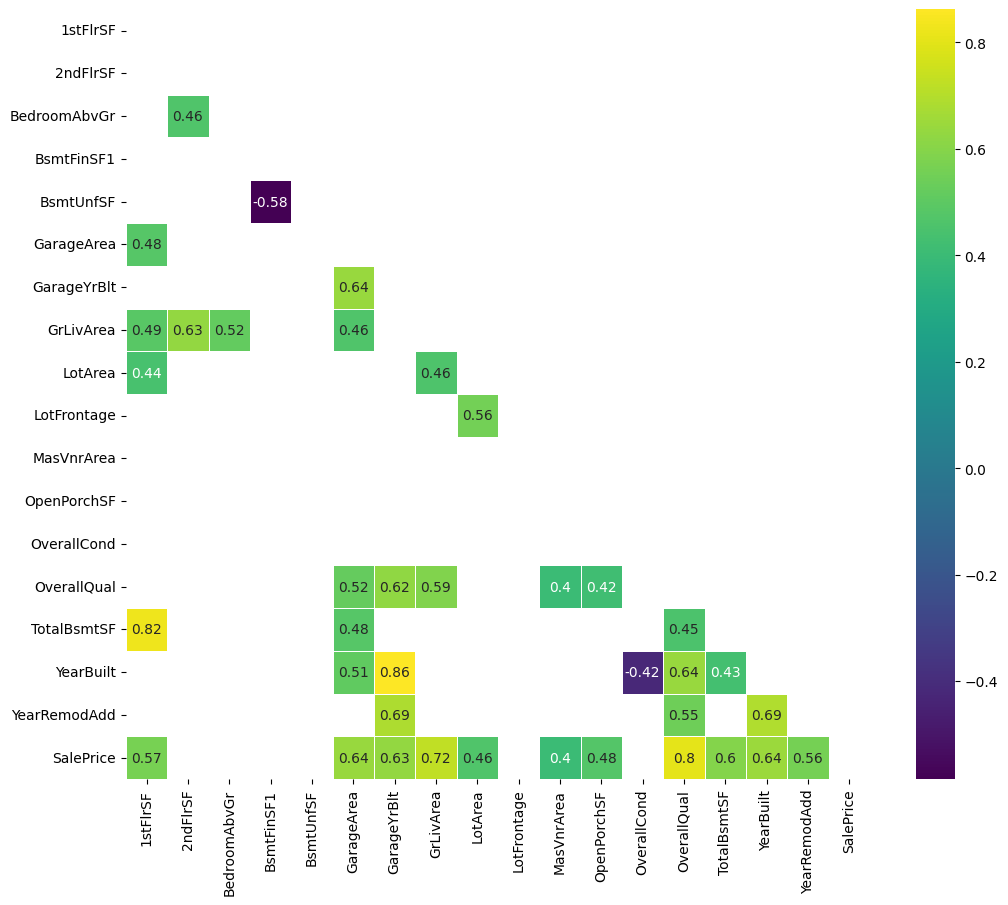



*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 



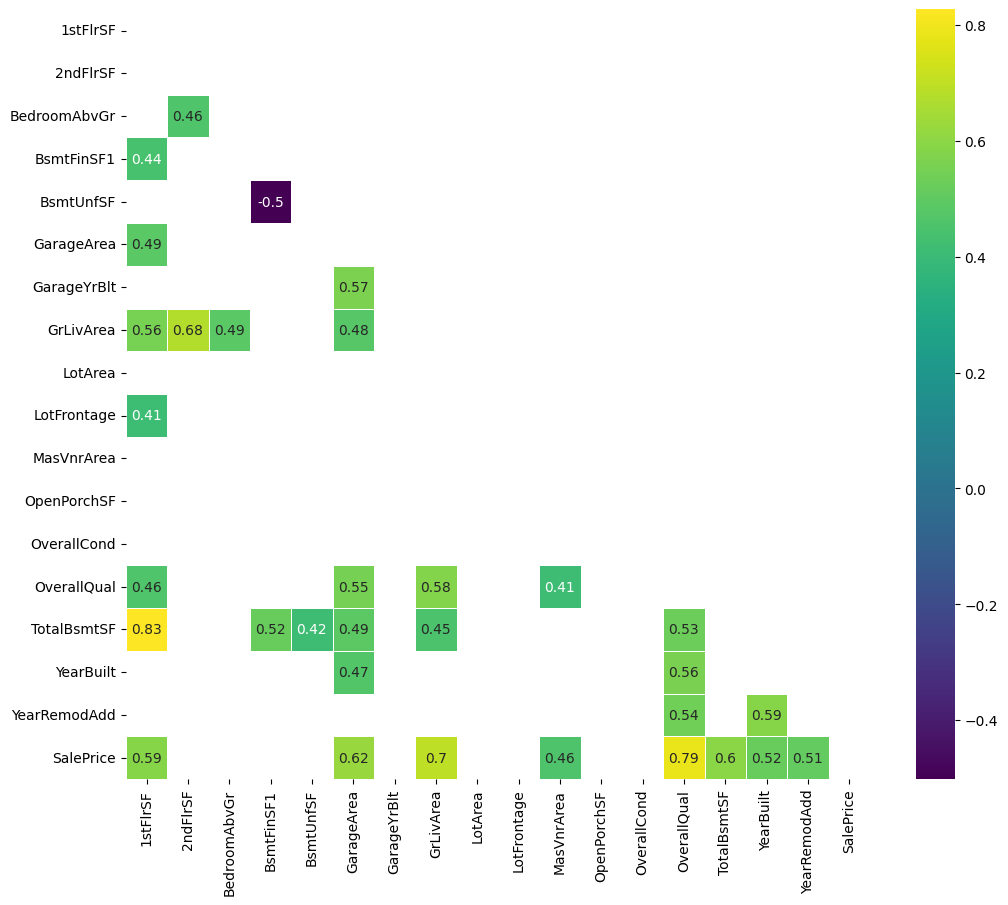



*** Heatmap: Power Predictive Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



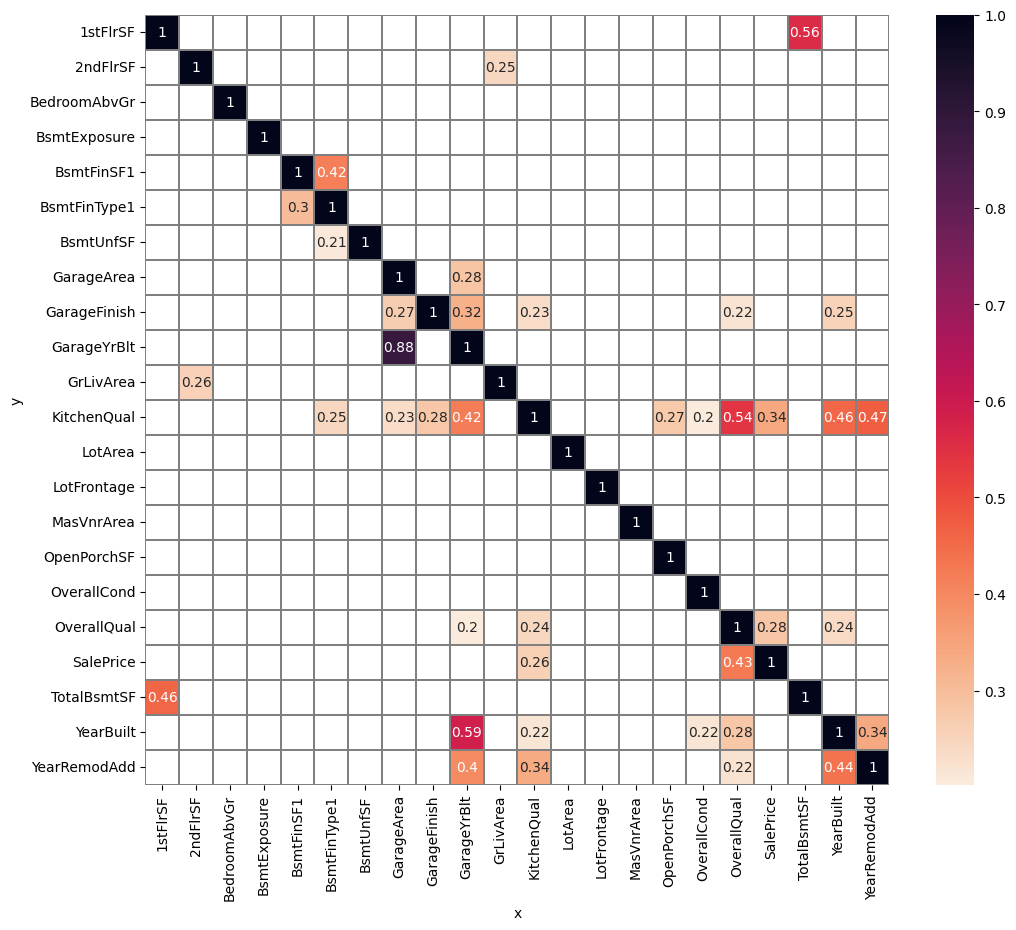

In [15]:
DisplayCorrAndPPS(df_corr_pearson = df_corr_pearson,
                  df_corr_spearman = df_corr_spearman, 
                  pps_matrix = pps_matrix,
                  CorrThreshold = 0.4, PPS_Threshold =0.2,
                  figsize=(12,10), font_annot=10)

In [16]:
spearman_vars = ['GrLivArea', 'OverallQual', 'GarageArea', 'GarageYrBlt', 'YearBuilt']
pearson_vars = ['GrLivArea', 'OverallQual', '1stFlrSF', 'GarageArea', 'TotalBsmtSF']
pps_vars = ['OverallQual', 'KitchenQual']

# Combine all and remove duplicates
important_vars = list(set(spearman_vars + pearson_vars + pps_vars))
print("Variables selected for plotting:", important_vars)

Variables selected for plotting: ['1stFlrSF', 'GarageYrBlt', 'KitchenQual', 'OverallQual', 'GarageArea', 'TotalBsmtSF', 'YearBuilt', 'GrLivArea']


In [17]:
def extract_top_predictors_with_values(df_corr_pearson, df_corr_spearman, pps_matrix, target='SalePrice', top_n=5):
    # Pearson
    top_pearson = df_corr_pearson[target].drop(target).abs().sort_values(ascending=False).head(top_n)
    top_pearson_df = pd.DataFrame({
        'Variable': top_pearson.index,
        'Pearson': top_pearson.values
    })

    # Spearman
    top_spearman = df_corr_spearman[target].drop(target).abs().sort_values(ascending=False).head(top_n)
    top_spearman_df = pd.DataFrame({
        'Variable': top_spearman.index,
        'Spearman': top_spearman.values
    })

    # PPS
    if target in pps_matrix.index:
        top_pps = pps_matrix.loc[target].drop(target).sort_values(ascending=False).head(top_n)
        top_pps_df = pd.DataFrame({
            'Variable': top_pps.index,
            'PPS': top_pps.values
        })
    else:
        top_pps_df = pd.DataFrame(columns=['Variable', 'PPS'])

    return top_pearson_df, top_spearman_df, top_pps_df


In [18]:
# Before Cleaning
df_corr_pearson_raw, df_corr_spearman_raw, pps_matrix_raw = CalculateCorrAndPPS(TrainSet)
top_pearson_raw, top_spearman_raw, top_pps_raw = extract_top_predictors_with_values(
    df_corr_pearson_raw, df_corr_spearman_raw, pps_matrix_raw
)

# After Cleaning
df_corr_pearson_clean, df_corr_spearman_clean, pps_matrix_clean = CalculateCorrAndPPS(TrainSet_cleaned)
top_pearson_clean, top_spearman_clean, top_pps_clean = extract_top_predictors_with_values(
    df_corr_pearson_clean, df_corr_spearman_clean, pps_matrix_clean
)


/Users/allaafaham/Library/Mobile Documents/com~apple~CloudDocs/cursor projects/house-prices/house-prices-env-py311/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  warnings.warn(
/Users/allaafaham/Library/Mobile Documents/com~apple~CloudDocs/cursor projects/house-prices/house-prices-env-py311/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  warnings.warn(


PPS threshold - check PPS score IQR to decide threshold for heatmap 

         count  mean    std  min  25%  50%    75%    max
ppscore  552.0  0.05  0.101  0.0  0.0  0.0  0.052  0.684
PPS threshold - check PPS score IQR to decide threshold for heatmap 

         count   mean    std  min  25%  50%    75%    max
ppscore  462.0  0.051  0.105  0.0  0.0  0.0  0.051  0.885


In [19]:
# Merge all into a single DataFrame
comparison_df = pd.DataFrame({
    'Pearson (Raw)': top_pearson_raw['Variable'],
    'Pearson Score (Raw)': top_pearson_raw['Pearson'].round(3),
    'Pearson (Cleaned)': top_pearson_clean['Variable'],
    'Pearson Score (Cleaned)': top_pearson_clean['Pearson'].round(3),

    'Spearman (Raw)': top_spearman_raw['Variable'],
    'Spearman Score (Raw)': top_spearman_raw['Spearman'].round(3),
    'Spearman (Cleaned)': top_spearman_clean['Variable'],
    'Spearman Score (Cleaned)': top_spearman_clean['Spearman'].round(3),

    'PPS (Raw)': top_pps_raw['Variable'],
    'PPS Score (Raw)': top_pps_raw['PPS'].round(3),
    'PPS (Cleaned)': top_pps_clean['Variable'],
    'PPS Score (Cleaned)': top_pps_clean['PPS'].round(3),
})

from IPython.display import display
display(comparison_df)


,Pearson (Raw),Pearson Score (Raw),Pearson (Cleaned),Pearson Score (Cleaned),Spearman (Raw),Spearman Score (Raw),Spearman (Cleaned),Spearman Score (Cleaned),PPS (Raw),PPS Score (Raw),PPS (Cleaned),PPS Score (Cleaned)
0,OverallQual,0.786,OverallQual,0.786,OverallQual,0.801,OverallQual,0.801,OverallQual,0.427,OverallQual,0.427
1,GrLivArea,0.696,GrLivArea,0.696,GrLivArea,0.723,GrLivArea,0.723,KitchenQual,0.260,KitchenQual,0.260
2,GarageArea,0.624,GarageArea,0.624,YearBuilt,0.643,YearBuilt,0.643,GarageArea,0.187,GarageArea,0.187
3,TotalBsmtSF,0.598,TotalBsmtSF,0.598,GarageArea,0.639,GarageArea,0.639,YearBuilt,0.178,YearBuilt,0.178
4,1stFlrSF,0.588,1stFlrSF,0.588,TotalBsmtSF,0.595,GarageYrBlt,0.626,GarageFinish,0.151,GarageYrBlt,0.155



### Summary of Results:

- **OverallQual** and **GrLivArea** consistently appear as the top predictors across all methods and remain unaffected by data cleaning, indicating high robustness and predictive power.
- **GarageArea**, **TotalBsmtSF**, and **1stFlrSF** show strong Pearson and Spearman correlations, with stable rankings before and after cleaning.
- **YearBuilt** rises in rank under Spearman and PPS, reflecting a non-linear or ordinal influence on `SalePrice` that is not as prominent under Pearson.
- **KitchenQual** emerges as a top predictor only under PPS, capturing categorical predictive strength missed by correlation coefficients.
- **GarageFinish** and **GarageYrBlt** show moderate PPS scores, suggesting non-linear relationships that improve slightly after imputation.

### Conclusion:

While cleaning had minimal impact on the top-ranking features, small shifts—particularly in variables like `GarageYrBlt` and `GarageFinish`—highlight the importance of re-evaluating feature importance post-cleaning. Using multiple correlation strategies offers a more comprehensive understanding of variable relevance for modeling.


## Save a copy of the cleand data

In [20]:
TrainSet_cleaned.info()
TestSet_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1168 entries, 254 to 1126
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   1stFlrSF      1168 non-null   int64  
 1   2ndFlrSF      1168 non-null   float64
 2   BedroomAbvGr  1168 non-null   float64
 3   BsmtExposure  1168 non-null   object 
 4   BsmtFinSF1    1168 non-null   int64  
 5   BsmtFinType1  1168 non-null   object 
 6   BsmtUnfSF     1168 non-null   int64  
 7   GarageArea    1168 non-null   int64  
 8   GarageFinish  1168 non-null   object 
 9   GarageYrBlt   1168 non-null   float64
 10  GrLivArea     1168 non-null   int64  
 11  KitchenQual   1168 non-null   object 
 12  LotArea       1168 non-null   int64  
 13  LotFrontage   1168 non-null   float64
 14  MasVnrArea    1168 non-null   float64
 15  OpenPorchSF   1168 non-null   int64  
 16  OverallCond   1168 non-null   int64  
 17  OverallQual   1168 non-null   int64  
 18  TotalBsmtSF   1168 non-null   i

In [21]:
import os
try:
  os.makedirs(name='outputs/datasets/collection') # create an output folder
except Exception as e:
  print(e)

TrainSet_cleaned.to_csv(f"outputs/datasets/collection/TrainSet_cleaned.csv",index=False)
TestSet_cleaned.to_csv(f"outputs/datasets/collection/TestSet_cleaned.csv",index=False)



[Errno 17] File exists: 'outputs/datasets/collection'


In [23]:
print(TrainSet['BsmtExposure'].dtypes)


object
